In [9]:
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from pandas import DataFrame, Series
from scipy.stats import combine_pvalues

In [5]:
# David's functions

@jit(nopython=True) # accelerator
def compute_liang_nvar(x,dt,n_iter):
    
    # Function to compute absolute transfer of information from xj to xi (T)
    def compute_liang_index(detC,Deltajk,Ckdi,Cij,Cii):
        T = (1. / detC) * np.sum(Deltajk * Ckdi) * (Cij / Cii) # absolute rate of information flowing from xj to xi (nats per unit time) (equation (14))
        return T
    
    # Function to compute relative transfer of information from xj to xi (tau)
    def compute_liang_index_norm(detC,Deltaik,Ckdi,T_all,Tii,gii,Cii,Tji):
        selfcontrib = (1. / detC) * np.sum(Deltaik * Ckdi) # self-contribution (equation (15))
        transfer = np.sum(np.abs(T_all)) - np.abs(Tii) # all other transfers contribution (equation (20))
        noise = 0.5 * gii / Cii # noise contribution
        Z = np.abs(selfcontrib) + transfer + np.abs(noise) # normalizer (equation (20))
        tau = 100. * Tji / Z # relative rate of information flowing from xj to xi (%) (equation (19))
        return tau
    
    # Dimensions
    nvar = x.shape[0] # number of variables
    N = x.shape[1] # length of the time series (number of observations)
    
    # Compute tendency dx
    k = 1 # k = 1 (or 2 for highly chaotic and densely sampled systems)
    dx = np.zeros((nvar,N)) # initialization of dx (to have the same number of time steps as x)
    for i in np.arange(nvar):
        dx[i,0:N-k] = (x[i,k:N] - x[i,0:N-k]) / (k * dt) # Euler forward finite difference of x (equation (7))
    
    # Compute covariances and matrix determinant
    C = np.cov(x) # covariance matrix
    dC = np.empty_like(C) * 0.
    for i in np.arange(nvar):
        for j in np.arange(nvar):
            dC[j,i] = (np.sum((x[j,:] - np.nanmean(x[j,:])) * (dx[i,:] - np.nanmean(dx[i,:])))) / (N - 1.) # covariance between x and dx
    detC = np.linalg.det(C) # matrix determinant
    
    # Compute cofactors
    Delta = np.linalg.inv(C).T * detC # cofactor matrix (https://en.wikipedia.org/wiki/Minor_(linear_algebra))
    
    # Compute absolute transfer of information (T) and correlation coefficient (R)
    T = np.zeros((nvar,nvar))
    R = np.zeros((nvar,nvar))
    for i in np.arange(nvar):
        for j in np.arange(nvar):
            T[j,i] = compute_liang_index(detC,Delta[j,:],dC[:,i],C[i,j],C[i,i]) # compute T (transfer of information from xj to xi) and create matrix
            R[j,i] = C[i,j] / np.sqrt(C[i,i] * C[j,j]) # compute correlation coefficient and create correlation matrix
    
    # Compute noise terms
    g = np.zeros(nvar)
    for i in np.arange(nvar):
        a1k = np.dot(np.linalg.inv(C),dC[:,i]) # compute a1k coefficients based on matrix-vector product (see beginning of page 4 in Liang (2014))
        f1 = np.nanmean(dx[i,:])
        for k in np.arange(nvar):
            f1 = f1 - a1k[k] * np.nanmean(x[k,:])
        R1 = dx[i,:] - f1
        for k in np.arange(nvar):
            R1 = R1 - a1k[k] * x[k,:]
        Q1 = np.sum(R1**2.)       
        g[i] = Q1 * dt / N # equation (10)
    
    # Compute relative transfer of information (tau)
    tau = np.zeros((nvar,nvar))
    for i in np.arange(nvar):
        for j in np.arange(nvar):
            tau[j,i] = compute_liang_index_norm(detC,Delta[i,:],dC[:,i],T[:,i],T[i,i],g[i],C[i,i],T[j,i]) # compute tau and create matrix
    
    # Initialize error in T, tau and R
    boot_T = np.zeros((n_iter,nvar,nvar))
    boot_tau = np.zeros((n_iter,nvar,nvar))
    boot_R = np.zeros((n_iter,nvar,nvar))
    
    # Compute error in T, tau and R using bootstrap with replacement
    for it in np.arange(n_iter): # loop over bootstrap realizations

        # Resample x and dx
        index = np.arange(N)
        boot_index = np.random.choice(index,N,replace=True) # resample index
        boot_x = np.zeros((nvar,N))
        boot_dx = np.zeros((nvar,N))
        for t in np.arange(N):
            boot_x[:,t] = x[:,boot_index[t]] # x corresponding to resampled index
            boot_dx[:,t] = dx[:,boot_index[t]] # dx corresponding to resampled index
        
        # Compute covariances and matrix determinant based on resampled variables
        boot_C = np.cov(boot_x)
        boot_dC = np.empty_like(boot_C) * 0.
        for i in np.arange(nvar):
            for j in np.arange(nvar):
                boot_dC[j,i] = (np.sum((boot_x[j,:] - np.nanmean(boot_x[j,:])) * (boot_dx[i,:] - np.nanmean(boot_dx[i,:])))) / (N - 1.)
        boot_detC = np.linalg.det(boot_C)
        
        # Compute cofactors based on resampled variables
        boot_Delta = np.linalg.inv(boot_C).T * boot_detC

        # Compute absolute transfer of information (T) and correlation coefficient (R) based on resampled variables
        for i in np.arange(nvar):
            for j in np.arange(nvar):
                boot_T[it,j,i] = compute_liang_index(boot_detC,boot_Delta[j,:],boot_dC[:,i],boot_C[i,j],boot_C[i,i])
                boot_R[it,j,i] = boot_C[i,j] / np.sqrt(boot_C[i,i] * boot_C[j,j])
        
        # Compute noise terms based on resampled variables
        boot_g = np.zeros(nvar)
        for i in np.arange(nvar):
            a1k = np.dot(np.linalg.inv(boot_C),boot_dC[:,i])
            f1 = np.nanmean(boot_dx[i,:])
            for k in np.arange(nvar):
                f1 = f1 - a1k[k] * np.nanmean(boot_x[k,:])
            R1 = boot_dx[i,:] - f1
            for k in np.arange(nvar):
                R1 = R1 - a1k[k] * boot_x[k,:]
            Q1 = np.sum(R1**2.)       
            boot_g[i] = Q1 * dt / N

        # Compute relative transfer of information (tau) based on resampled variables
        for i in np.arange(nvar):
            for j in np.arange(nvar):
                boot_tau[it,j,i] = compute_liang_index_norm(boot_detC,boot_Delta[i,:],boot_dC[:,i],boot_T[it,:,i],boot_T[it,i,i],boot_g[i],boot_C[i,i],boot_T[it,j,i])

    # Compute error in T, tau and R (standard deviation of boostraped values)
    # error_T = np.nanstd(boot_T,axis=0)
    # error_tau = np.nanstd(boot_tau,axis=0)
    # error_R = np.nanstd(boot_R,axis=0)
    
    # Return result of function
    return T, tau, R, boot_T, boot_tau, boot_R

In [ ]:
# Benjamin's functions

MULTI_LIANG_RES_NAMES = [
    "T",
    "tau",
    "R",
    "error_T",
    "error_tau",
    "error_R",
]
MODELS = [
    "EC-Earth3",
    "CESM2",
    "MPI-ESM1-2-LR",
    "CanESM5",
    "ACCESS-ESM1-5",
    "Observations",
]
MODEL_NAMES = MODELS[:-1] 
MODEL_COLOURS = {
    "EC-Earth3": "red",
    "CESM2": "blue",
    "MPI-ESM1-2-LR": "gray",
    "CanESM5": "green",
    "ACCESS-ESM1-5": "orange",
    "Observations": "k--"
}
VAR_YLABELS_SHORT = {
    "ssie": "SSIE",
    "wsie": "WSIE",
    "tas": "$T_{2m}$",
    "wsiv": "WSIV",
    "oht_atl": "$OHT_{ATL}$",
    "oht_pac": "$OHT_{PAC}$",
}
VARIABLES = [
    "ssie",     # September sea ice extent
    "wsie",     # March sea ice extent
    "wsiv",     # March sea ice volume
    "tas",      # 
    "oht_atl",  # Atlantic ocean heat transport
    "oht_pac",  # Pacific ocean heat transport
    "swfd",     # 
    "lwfd",
]
VAR_OBS_START_YEARS = {
    "ssie": 1979,
    "wsie": 1979, 
    "wsiv": 1979,
    "tas": 1970,
    "oht_atl": 1979,
    "oht_pac": 1979,
    "swfd": 2001,
    "lwfd": 2001,
}
MODEL_START_YEAR = 1970
MODEL_END_YEAR = 2100

def get_year_list(start_year: int, end_year: int) -> list[datetime]:
    return [datetime(year, 1, 1) for year in range(start_year, end_year+1)]

def calculate_ensemble_mean(model_data: np.ndarray) -> np.ndarray:
    return model_data.mean(axis=1)

def read_model_data(data_location, model: str) -> tuple:
    ssie, wsie, wsiv, tas, oht_atl, oht_pac, swfd, lwfd = np.load(f'{data_location}/Timeseries_{model}.npy', allow_pickle=True)
    return ssie, wsie, wsiv, tas, oht_atl, oht_pac, swfd, lwfd

def read_model_data_all(data_location: str) -> dict:
    model_data_in = {
        model: dict(zip(VARIABLES, read_model_data(data_location, model))) for model in MODELS
    }
    model_data = {}
    for var in VARIABLES:
        model_dict = {}
        for model in MODELS:
            data = model_data_in[model][var]
            if model == "Observations":
                if var in ("oht_atl", "oht_pac"):
                    # The OHT observations are actually reanalyses,
                    # so need to take the ensemble mean
                    data = calculate_ensemble_mean(DataFrame(data.T))
                data = Series(data)
                data.index = get_year_list(VAR_OBS_START_YEARS[var], VAR_OBS_START_YEARS[var]+data.shape[0]-1)
            else:
                data = DataFrame(data.T)
                if model == "CanESM5" and var not in ("oht_atl", "oht_pac"):
                    # Drop last ensemble member so that all CanESM5 variables
                    # have the same number of ensemble members
                    data = data.drop(columns=[49]) 
                data.index = get_year_list(MODEL_START_YEAR, MODEL_END_YEAR)
            model_dict[model] = data
        model_data[var] = model_dict
    
    return model_data

def subtract_ensemble_mean(model_data: DataFrame) -> DataFrame:
    return model_data.subtract(model_data.mean(axis=1), axis=0)

def filter_by_years(
        model_data: Series | DataFrame,
        start_year: str,
        end_year: str,
    ) -> Series | DataFrame:
    if isinstance(start_year, int):
        start_year = f'{start_year}-01-01'
    if isinstance(end_year, int):
        end_year = f'{end_year}-01-01'
    return model_data.loc[start_year:end_year].copy()

def prepare_for_liang(data: DataFrame, start: str, end: str) -> DataFrame:
    filtered = filter_by_years(data, start, end).fillna(0)
    return subtract_ensemble_mean(filtered).to_numpy()

def prepare_liang_array(liang_data, i, y):
    data_list = []
    for var_data in liang_data.values():
        data_list.append(var_data[:, i])  # Access the ith column of each variable's data
    return np.array([*data_list, y])

def compute_liang_nvar_wrapper(x, dt, n_iter):
    res = dict(zip(
        MULTI_LIANG_RES_NAMES,
        compute_liang_nvar(x, dt, n_iter),
    ))
    res["error_T"] = np.nanstd(res["error_T"],axis=0)
    res["error_tau"] = np.nanstd(res["error_tau"],axis=0)
    res["error_R"] = np.nanstd(res["error_R"],axis=0)
    return res

def calculate_liang_model_flows(liang_data, y, dt, n_iter):
    liang_indexes = []
    p_values = []

    for i in range(y.shape[1]):
        x = prepare_liang_array(liang_data, i, y[:, i])

        res = compute_liang_nvar_wrapper(x, dt, n_iter)

        tau = abs(res["tau"])
        p_value = calculate_pvalue(tau, res["error_tau"])

        liang_indexes.append(tau[:,4])
        p_values.append(p_value[:,4])

    return liang_indexes, p_values

def calculate_pvalue(tau, error_tau):
    z = tau / error_tau
    return np.exp(-0.717 * z - 0.416 * z**2)

def calculate_tau_avg(liang_indexes, var_liangs):
    tau_avg = np.nanmean(np.array(liang_indexes), axis=0)
    return dict(zip(var_liangs, tau_avg))

def calculate_combined_pvalues(p_values, var_liangs):
    p_array = np.array(p_values)
    return {
        var: combine_pvalues(p_array[:, i], method='fisher')[1]
            for i, var in enumerate(var_liangs)
    }

def calculate_all_liang_flows(
        model_data: dict,
        y_var: str,
        var_liangs: list[str],
        liang_start: str,
        liang_end: str,
        dt: int = 1,
        n_iter: int = 1000,
    ) -> dict:
    tau_avgs = {}
    combined_pvalues = {}
    ensemble_flows = {}
    ensemble_pvalues = {}
    for model in MODEL_NAMES:
        # Prepare data for liang flow calc
        ssie_liang = prepare_for_liang(model_data[y_var][model], liang_start, liang_end)
        liang_data = {
            var: prepare_for_liang(model_data[var][model], liang_start, liang_end) for var in var_liangs
        }

        # Liang flow calc
        liang_indexes, p_values = calculate_liang_model_flows(liang_data, ssie_liang, dt, n_iter)

        # Add ensemble flows and pvalues
        ensemble_flows[model] = np.array(liang_indexes)
        ensemble_pvalues[model] = p_values

        # Add ensemble mean flow and pvalue
        tau_avgs[model] = calculate_tau_avg(liang_indexes, var_liangs)
        combined_pvalues[model] = calculate_combined_pvalues(p_values, var_liangs)

    return {
        "tau_avgs": tau_avgs,
        "combined_pvalues": combined_pvalues,
        "ensemble_flows": ensemble_flows,
        "ensemble_pvalues": ensemble_pvalues,
    }

def plot_liang_tau_avgs(liang_res, var_liangs):
    fig, ax = plt.subplots()
    ax.grid(linestyle='--')

    jitter = 0.1

    for j, var in enumerate(var_liangs):
        for i, model in enumerate(MODEL_NAMES):

            tau = liang_res["tau_avgs"][model][var]
            pvalue = liang_res["combined_pvalues"][model][var]
            x = j - 0.2 + i * jitter

            # Black circle if significant
            kwargs = {"edgecolors": 'black', "linewidths": 2} if pvalue <= 0.05 else {}

            ax.scatter(x, tau, label=model, c=MODEL_COLOURS[model], s=100, **kwargs)

    ax.set_xticks(range(len(var_liangs)))
    ax.set_xticklabels([VAR_YLABELS_SHORT[var] for var in var_liangs])
    ax.set_ylabel("Information Transfer")
    ax.axhline(0, color='black', linestyle='--')
    ax.set_ylim(-1, 30)
    ax.grid(linestyle='--')
    ax.set_axisbelow(True)

    plt.tight_layout()

In [11]:
data_location = "./data"

model_data = read_model_data_all(data_location)

In [1]:
model_data

NameError: name 'model_data' is not defined

In [ ]:
dt = 1
n_iter = 1000
liang_start = "1970-01-01"
liang_end = "2060-01-01"
var_liangs = ["wsiv", "tas", "oht_atl", "oht_pac"]
target_var = "ssie"


liang_res = calculate_all_liang_flows(model_data, target_var, var_liangs, liang_start, liang_end)

C:\Users\bensi\AppData\Local\Temp\ipykernel_21320\3490044952.py:52: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'F', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  a1k = np.dot(np.linalg.inv(C),dC[:,i]) # compute a1k coefficients based on matrix-vector product (see beginning of page 4 in Liang (2014))


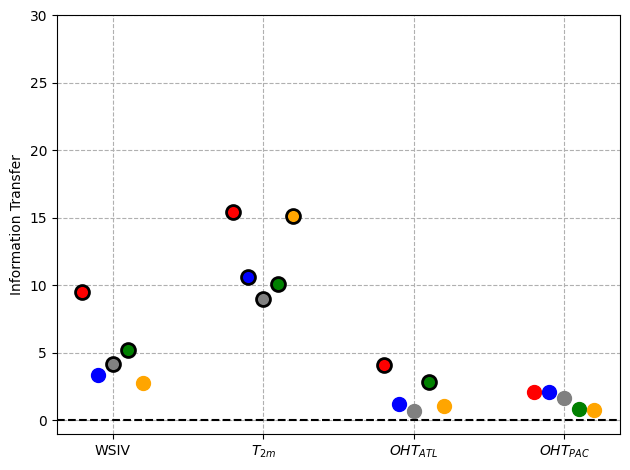

In [13]:
plot_liang_tau_avgs(liang_res, var_liangs)